## San Francisco BikeShare Data Project
#### W205 - Project 1
#### Student Name: Matt Pribadi
---

#### Install packages to be used

In [ ]:
!pip install google-cloud-bigquery-storage
!pip install geopandas
!conda install -c plotly plotly --yes
!pip install vincenty

#### Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import vincenty
from shapely.geometry import Point, Polygon
import warnings
warnings.filterwarnings('ignore')

#### SQL Queries

### Query for the most popular stations

#### Assumptions:
- Commuters only work on Weekdays
- Commuters are typically bikeshare subscribers

In [2]:
%%bigquery commute_df
SELECT 
    distinct start_station_name, end_station_name, count(*) as count_sub,
    
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    
WHERE subscriber_type LIKE 'Subscriber'
    AND NOT (EXTRACT(DAYOFWEEK FROM start_date) = 1 
             OR EXTRACT(DAYOFWEEK FROM start_date) = 7) 
    
GROUP BY start_station_name, end_station_name 

ORDER BY count_sub DESC

Downloading: 100%|██████████| 1966/1966 [00:01<00:00, 1477.01rows/s]


In [3]:
%%bigquery start_df
SELECT 
    distinct Station.latitude, 
    Station.longitude, 
    Trips.start_station_name,
FROM 
    `bigquery-public-data.san_francisco.bikeshare_stations` as Station 
join 
    `bigquery-public-data.san_francisco.bikeshare_trips` as Trips on Trips.start_station_id=Station.station_id
GROUP BY
    Station.latitude,
    Station.longitude,
    Station.station_id,
    Trips.start_station_name

Downloading: 100%|██████████| 84/84 [00:01<00:00, 56.63rows/s]


In [4]:
%%bigquery end_df
SELECT 
    distinct Station.latitude, 
    Station.longitude, 
    Trips.end_station_name,
FROM 
    `bigquery-public-data.san_francisco.bikeshare_stations` as Station 
join 
    `bigquery-public-data.san_francisco.bikeshare_trips` as Trips on Trips.end_station_id=Station.station_id
GROUP BY
    Station.latitude,
    Station.longitude,
    Station.station_id,
    Trips.end_station_name

Downloading: 100%|██████████| 84/84 [00:01<00:00, 57.18rows/s]


---

#### Begin data exploration using Python

In [5]:
commute_df.head(5)

start_station_name  \
0  San Francisco Caltrain 2 (330 Townsend)   
1                          2nd at Townsend   
2                          Townsend at 7th   
3     Harry Bridges Plaza (Ferry Building)   
4                    Embarcadero at Folsom   

                           end_station_name  count_sub  
0                           Townsend at 7th       7870  
1      Harry Bridges Plaza (Ferry Building)       6655  
2   San Francisco Caltrain 2 (330 Townsend)       6322  
3                           2nd at Townsend       6070  
4  San Francisco Caltrain (Townsend at 4th)       6028

In [6]:
start_df.columns = ['start_latitude', 'start_longitude', 'start_station_name']

In [7]:
start_df.head()

start_latitude  start_longitude                start_station_name
0       37.333988      -121.894902            Santa Clara at Almaden
1       37.448598      -122.159504              Cowper at University
2       37.444521      -122.163093            University and Emerson
3       37.385956      -122.083678  Castro Street and El Camino Real
4       37.342725      -121.895617                       Ryland Park

In [8]:
end_df.columns = ['end_latitude', 'end_longitude', 'end_station_name']

In [9]:
end_df.head()

end_latitude  end_longitude end_station_name
0     37.491269    -122.236234            Mezes
1     37.348742    -121.894715        Japantown
2     37.491269    -122.236234       Mezes Park
3     37.335885    -121.885660      MLK Library
4     37.342725    -121.895617      Ryland Park

In [10]:
combined = pd.merge(commute_df, start_df, how = 'inner', on = 'start_station_name')
combined = pd.merge(combined, end_df, how = 'inner', on = 'end_station_name')
combined = combined.sort_values('count_sub', ascending = False)
combined.head()

start_station_name  \
0     San Francisco Caltrain 2 (330 Townsend)   
157                           2nd at Townsend   
1183                          Townsend at 7th   
883      Harry Bridges Plaza (Ferry Building)   
1262                    Embarcadero at Folsom   

                              end_station_name  count_sub  start_latitude  \
0                              Townsend at 7th       7870       37.776600   
157       Harry Bridges Plaza (Ferry Building)       6655       37.780526   
1183   San Francisco Caltrain 2 (330 Townsend)       6322       37.771058   
883                            2nd at Townsend       6070       37.795392   
1262  San Francisco Caltrain (Townsend at 4th)       6028       37.791464   

      start_longitude  end_latitude  end_longitude  
0         -122.395470     37.771058    -122.402717  
157       -122.390288     37.795392    -122.394203  
1183      -122.402717     37.776600    -122.395470  
883       -122.394203     37.780526    -122.390288  
1262      -122.391034     37.776617    -122.395260

In [11]:
combined_df5 = combined.head(5)
combined_df5

start_station_name  \
0     San Francisco Caltrain 2 (330 Townsend)   
157                           2nd at Townsend   
1183                          Townsend at 7th   
883      Harry Bridges Plaza (Ferry Building)   
1262                    Embarcadero at Folsom   

                              end_station_name  count_sub  start_latitude  \
0                              Townsend at 7th       7870       37.776600   
157       Harry Bridges Plaza (Ferry Building)       6655       37.780526   
1183   San Francisco Caltrain 2 (330 Townsend)       6322       37.771058   
883                            2nd at Townsend       6070       37.795392   
1262  San Francisco Caltrain (Townsend at 4th)       6028       37.791464   

      start_longitude  end_latitude  end_longitude  
0         -122.395470     37.771058    -122.402717  
157       -122.390288     37.795392    -122.394203  
1183      -122.402717     37.776600    -122.395470  
883       -122.394203     37.780526    -122.390288  
1262      -122.391034     37.776617    -122.395260

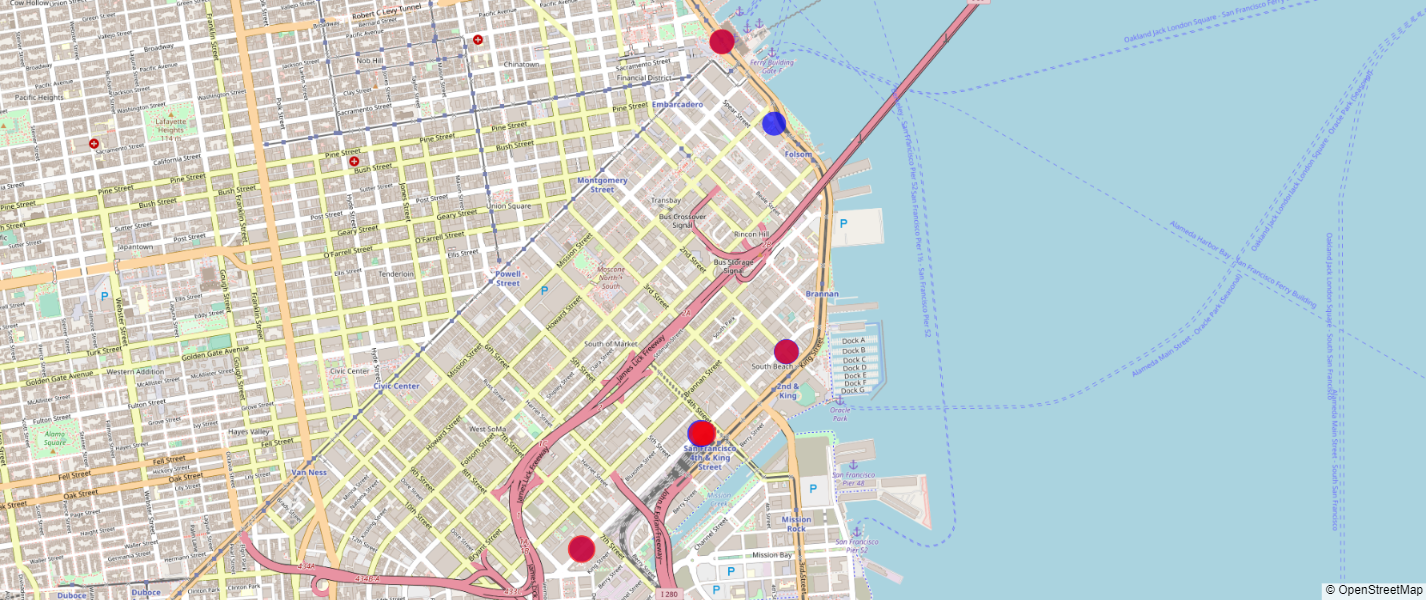

In [12]:
import plotly.express as px


fig = px.scatter_mapbox(combined_df5, lat="start_latitude", lon="start_longitude", hover_name="start_station_name", hover_data=["count_sub"],
                        color_discrete_sequence=["blue"], height=600, size=combined_df5['count_sub'], zoom = 13.5 )
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig2 = px.scatter_mapbox(combined_df5, lat="end_latitude", lon="end_longitude", hover_name="end_station_name", hover_data=["count_sub"],
                        color_discrete_sequence=["red"], height=600, size=combined_df5['count_sub'], zoom = 13.5 )
fig2.update_layout(mapbox_style="open-street-map")
fig.add_trace(fig2.data[0])
fig.show()

In [13]:
commute_df.head(5)

start_station_name  \
0  San Francisco Caltrain 2 (330 Townsend)   
1                          2nd at Townsend   
2                          Townsend at 7th   
3     Harry Bridges Plaza (Ferry Building)   
4                    Embarcadero at Folsom   

                           end_station_name  count_sub  
0                           Townsend at 7th       7870  
1      Harry Bridges Plaza (Ferry Building)       6655  
2   San Francisco Caltrain 2 (330 Townsend)       6322  
3                           2nd at Townsend       6070  
4  San Francisco Caltrain (Townsend at 4th)       6028

**What are the 5 most popular trips that you would call "commuter trips"?**

*The 5 most popular trips are shown in the "commute_df" table shown above. When plotted based on their geographic locations, these stations follow Townsend street and The Embarcadero with the most starts and stops culminating at the caltrain stations on Townsend and 4th street. This makes sense as many people are getting off the commuter train and are taking a bike to work.*

---

**Project Question 2: What are your recommendations for offers (justify based on your findings)?**

#### Question 1: **Which station requires the most number of bikes per hour?**

In [32]:
%%bigquery available_bikes
  SELECT  Status.station_id, AVG(Status.bikes_available)/max(dockcount) as available_ratio, (EXTRACT (HOUR FROM Status.time) ) AS query_hour
  FROM 
    `bigquery-public-data.san_francisco.bikeshare_status` as Status 
  JOIN 
    `bigquery-public-data.san_francisco.bikeshare_stations` as Stations on Stations.station_id=Status.station_id
  GROUP BY Status.station_id, query_hour
  ORDER BY query_hour

Downloading: 100%|██████████| 1776/1776 [00:01<00:00, 1152.76rows/s]


In [33]:
#Convert bikes available to a round integer number (no partial bikes)
#available_bikes['available_ratio'] = available_bikes['available_ratio'].astype(int)
available_bikes.head()

station_id  available_ratio  query_hour
0          91         0.181826           0
1          90         0.648489           0
2          88         0.473684           0
3          89         0.315639           0
4           2         0.475387           0

In [34]:
#Using pandas pivot table to create heat map data
hm_data = pd.pivot_table(available_bikes, values='available_ratio', index=['station_id'], columns='query_hour')

Text(0.5, 195.0, 'Hour of the Day')

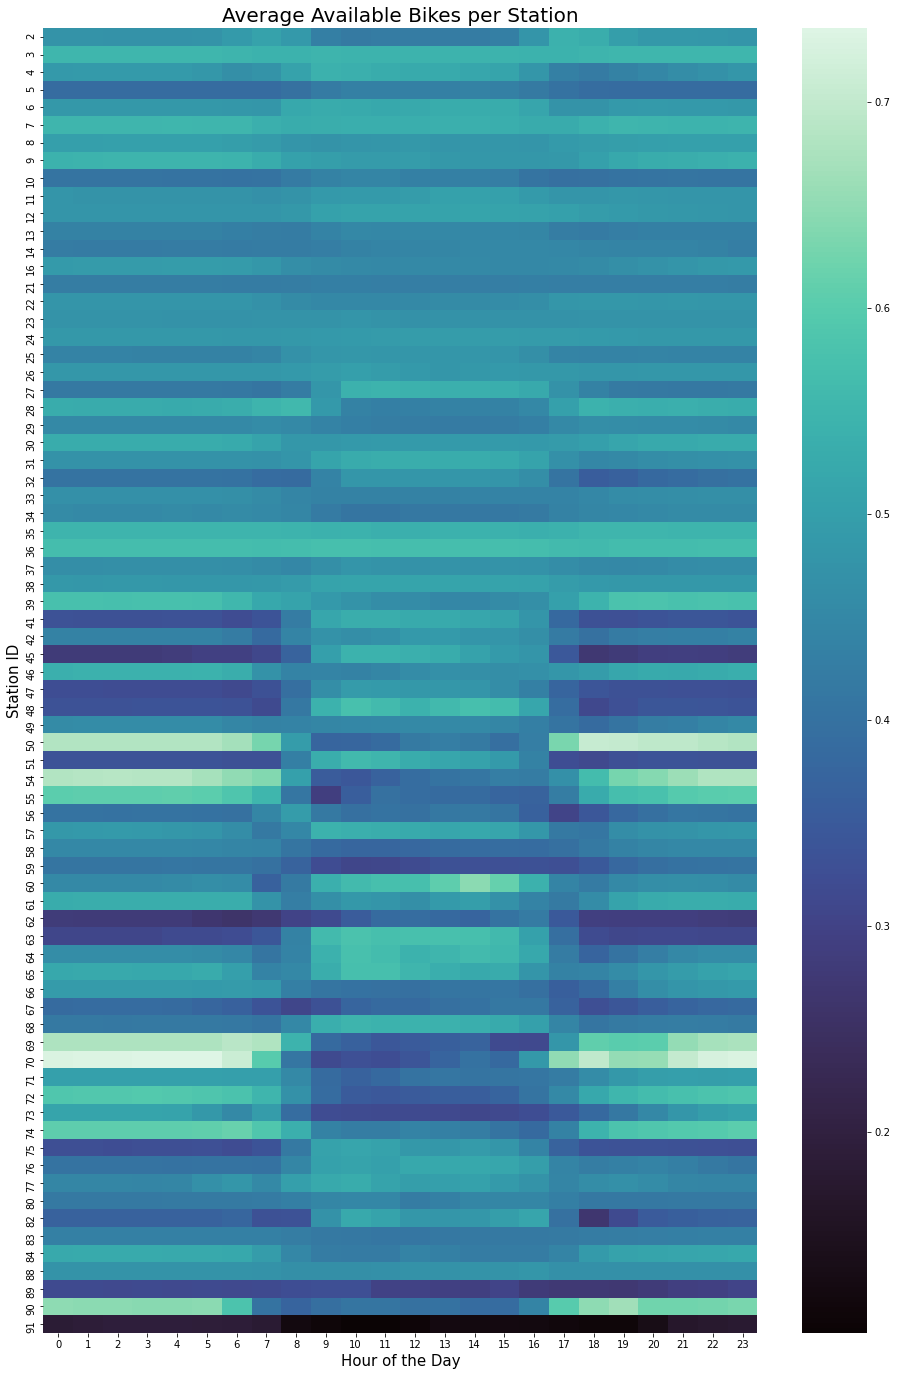

In [35]:
fig, ax = plt.subplots(figsize=(16,24))
sns.heatmap(hm_data, cmap = 'mako')

plt.title('Average Available Bikes per Station', fontsize = 20)
ax.set_ylabel('Station ID', fontsize = 15)
ax.set_xlabel('Hour of the Day', fontsize = 15)

The heatmap above shows a ratio of how many bikes are available for rent based normalized for the number of bike docks are available. This shows that there are some staions that are always empty and could use more bikes and docks (for example, this would include stations 91, 89, 62). There are also some stations that are never used and could be relocated elsewhere such as 3, 7, 35, 36.

----

#### Question 2: Subscriber type versus average commuter distance?

In [36]:
#Beginning from the "combined" dataframe from the question answered above:
combined.head()

start_station_name  \
0     San Francisco Caltrain 2 (330 Townsend)   
157                           2nd at Townsend   
1183                          Townsend at 7th   
883      Harry Bridges Plaza (Ferry Building)   
1262                    Embarcadero at Folsom   

                              end_station_name  count_sub  start_latitude  \
0                              Townsend at 7th       7870       37.776600   
157       Harry Bridges Plaza (Ferry Building)       6655       37.780526   
1183   San Francisco Caltrain 2 (330 Townsend)       6322       37.771058   
883                            2nd at Townsend       6070       37.795392   
1262  San Francisco Caltrain (Townsend at 4th)       6028       37.791464   

      start_longitude  end_latitude  end_longitude  
0         -122.395470     37.771058    -122.402717  
157       -122.390288     37.795392    -122.394203  
1183      -122.402717     37.776600    -122.395470  
883       -122.394203     37.780526    -122.390288  
1262      -122.391034     37.776617    -122.395260

In [37]:
from numpy import cos, sin, arcsin, sqrt
from math import radians

In [38]:
#Calculate distances between the start and end stations:

from shapely.geometry import Point

def haversine(row):
    lon1 = row['start_longitude']
    lat1 = row['start_latitude']
    lon2 = row['end_longitude']
    lat2 = row['end_latitude']
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * arcsin(sqrt(a)) 
    km = 6367 * c
    mi = 0.621371*km
    return mi

combined['distance'] = combined.apply(lambda row: haversine(row), axis=1)
combined

start_station_name  \
0     San Francisco Caltrain 2 (330 Townsend)   
157                           2nd at Townsend   
1183                          Townsend at 7th   
883      Harry Bridges Plaza (Ferry Building)   
1262                    Embarcadero at Folsom   
...                                       ...   
685             Redwood City Caltrain Station   
1850                    San Jose Civic Center   
1571                  San Mateo County Center   
1257              Cyril Magnin St at Ellis St   
1854                              MLK Library   

                              end_station_name  count_sub  start_latitude  \
0                              Townsend at 7th       7870       37.776600   
157       Harry Bridges Plaza (Ferry Building)       6655       37.780526   
1183   San Francisco Caltrain 2 (330 Townsend)       6322       37.771058   
883                            2nd at Townsend       6070       37.795392   
1262  San Francisco Caltrain (Townsend at 4th)       6028       37.791464   
...                                        ...        ...             ...   
685                  Broadway St at Battery St          1       37.486078   
1850           Santa Clara County Civic Center          1       37.330698   
1571                             Park at Olive          1       37.487616   
1257             Powell at Post (Union Square)          1       37.785908   
1854                  S. Market St at Park Ave          1       37.335885   

      start_longitude  end_latitude  end_longitude   distance  
0         -122.395470     37.771058    -122.402717   0.550354  
157       -122.390288     37.795392    -122.394203   1.048492  
1183      -122.402717     37.776600    -122.395470   0.550354  
883       -122.394203     37.780526    -122.390288   1.048492  
1262      -122.391034     37.776617    -122.395260   1.050804  
...               ...           ...            ...        ...  
685       -122.232089     37.798541    -122.400862  23.466098  
1850      -121.888979     37.352601    -121.905733   1.770108  
1571      -122.229951     37.425684    -122.137777   6.619156  
1257      -122.408891     37.788446    -122.408499   0.176549  
1854      -121.885660     37.332398    -121.890429   0.355708  

[1966 rows x 8 columns]

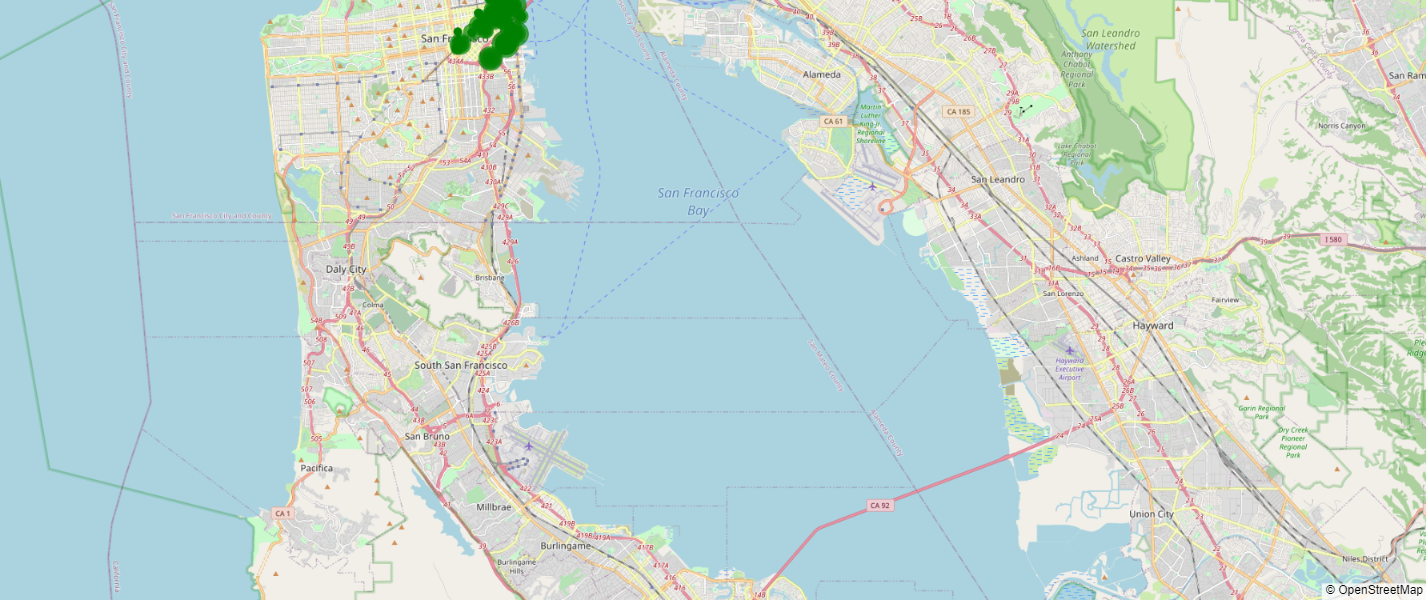

In [40]:
fig = px.scatter_mapbox(combined, lat="start_latitude", lon="start_longitude", hover_name="start_station_name", hover_data=["distance"],
                        color_discrete_sequence=["green"], height=600, size=combined['count_sub'], zoom = 10.5 )
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

From the map above, the circles represent each starting location. The larger the circle, the further of a commute the average customer rides. This information may help determine where new stations need to be built or moved depending on the demand and where people are travelling to

---

#### Question 3: Subscriber type versus average commuter time?

In [41]:
%%bigquery duration_df
SELECT 
    distinct trip_id, duration_sec/60 as duration_min, subscriber_type
    
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    
WHERE duration_sec < 86400 and duration_sec > 300

Downloading: 100%|██████████| 803273/803273 [00:01<00:00, 561391.08rows/s] 


In [42]:
duration_sub = duration_df.groupby('subscriber_type')
sub_group = duration_sub.get_group('Subscriber')

duration_sub['duration_min'].describe()

count       mean         std       min        25%  \
subscriber_type                                                         
Customer         131280.0  55.487536  119.057728  5.016667  11.783333   
Subscriber       671993.0  10.999382   23.313471  5.016667   7.033333   

                       50%        75%          max  
subscriber_type                                     
Customer         19.583333  41.566667  1439.683333  
Subscriber        9.166667  12.066667  1431.666667

In [43]:
cust_group = duration_sub.get_group('Customer')
cust_group.describe()

trip_id   duration_min
count  1.312800e+05  131280.000000
mean   5.835579e+05      55.487536
std    4.022048e+05     119.057728
min    4.078000e+03       5.016667
25%    2.314168e+05      11.783333
50%    5.328810e+05      19.583333
75%    9.097415e+05      41.566667
max    1.338378e+06    1439.683333

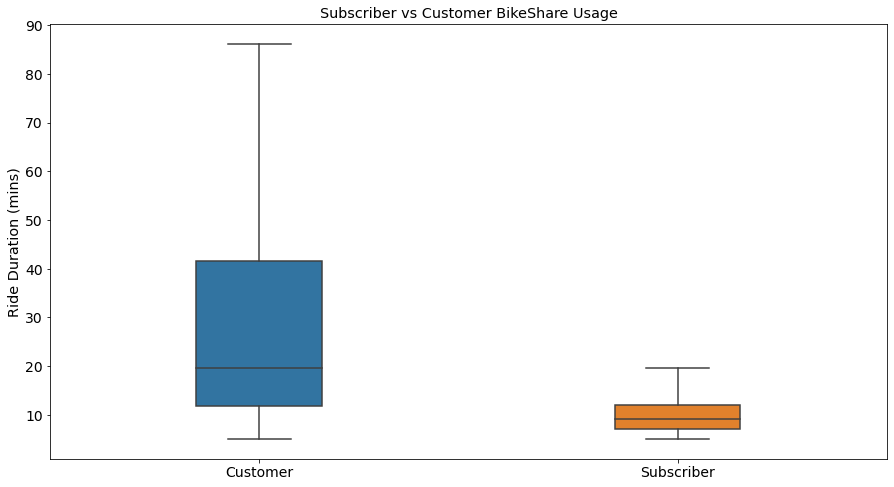

In [44]:
fig, ax = plt.subplots(figsize=(15,8))

ax = sns.boxplot(y = 'duration_min', x = 'subscriber_type', data = duration_df, showfliers = False, width = 0.3)
#ax = sns.stripplot(y = 'duration_min', x = 'subscriber_type', data = duration_df, alpha = 0.75)

ax.set_ylabel('Ride Duration (mins)', fontsize = 'x-large')
ax.set_xlabel('')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_title('Subscriber vs Customer BikeShare Usage', fontsize = 'x-large')

plt.show()

Lyft BayWheels Bikeshare costs from the website:

- Annual Membership = \\$13.25 per month with \\$159 billed up front annually
 - Included ride time: 45 minutes
 - Unlock fee \\$0.00
 - Cost per additional 15 mins \\$2.00
 
 
- Single trips:
 - Included ride time: 30 minutes
 - Unlock fee \\$3.00
 - Cost per additional 15 mins: \\$3.00
 - Based on an average of 56 minutes, average cost is: \\$3 + \\$5.20 = **\\$8.20**
 
 
---

#### Question 4: Trips taken per hour?

In [45]:
%%bigquery trip_per_hour

    SELECT EXTRACT(HOUR FROM start_date) as start_hour, count(*) as total_rides,
    SUM(CASE WHEN EXTRACT(DAYOFWEEK FROM start_date) BETWEEN 1 AND 6 
        THEN 1 ELSE 0 END) AS weekday,
    SUM(CASE WHEN EXTRACT(DAYOFWEEK FROM start_date)=0 
        OR EXTRACT(DAYOFWEEK FROM start_date)=7 
            THEN 1 ELSE 0 END) AS weekend,
    SUM(CASE WHEN subscriber_type = 'Subscriber' 
        THEN 1 ELSE 0 END) AS subscriber,
    SUM(CASE WHEN subscriber_type = 'Customer' 
        THEN 1 ELSE 0 END) AS customer  
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    GROUP BY start_hour
    ORDER BY start_hour

Downloading: 100%|██████████| 24/24 [00:01<00:00, 15.59rows/s]


In [46]:
trip_per_hour.head()

start_hour  total_rides  weekday  weekend  subscriber  customer
0           0         2929     2284      645        2081       848
1           1         1611     1193      418         972       639
2           2          877      652      225         464       413
3           3          605      531       74         397       208
4           4         1398     1329       69        1238       160

Text(0.5, 1.0, 'Hour Breakdown of Trips')

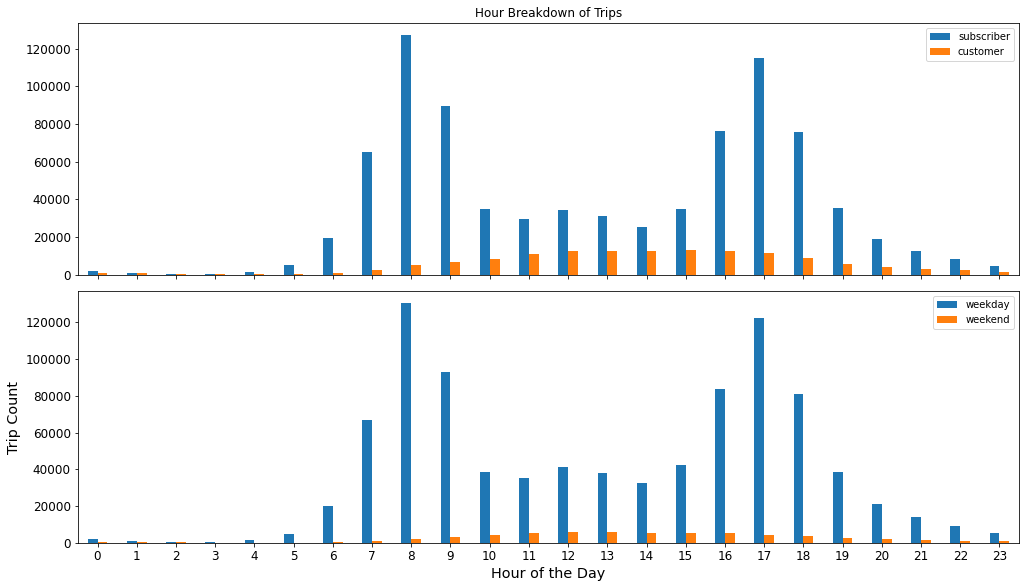

In [47]:
#Generate plots breaking down weekend/weekday and subscriber type per hour

fig, axes = plt.subplots(2,1,figsize=(14,8), sharex = True)
trip_per_hour.plot(ax=axes[0], x="start_hour", y=["subscriber", "customer"], kind="bar")
trip_per_hour.plot(ax=axes[1], x="start_hour", y=["weekday", "weekend"], kind="bar")

fig.tight_layout()

plt.xticks(rotation = 0)
plt.xlabel("Hour of the Day", fontsize = 'x-large')
plt.ylabel("Trip Count", fontsize = 'x-large')
axes[0].tick_params(axis='both', which='major', labelsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=12)
axes[0].set_title('Hour Breakdown of Trips')

Bike usage per hour correlates heavily with subscriber usage. Clearly the most bikes are used during the weekdays with the numbers drastically following on the weekends. Maybe we could add some incentives for subscribers to use the bikes on the weekends (longer free bike usage, etc.)